# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 21.09.2020

Мягкий дедлайн: 02:59MSK 05.10.2020

Жесткий дедлайн: 23:59MSK 08.10.2020

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [1]:
!pip install folium

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [4]:
samp_sub_path = 'nyc-taxi-trip-duration/sample_submission.csv'
test_path = 'nyc-taxi-trip-duration/test.csv'
train_path = 'nyc-taxi-trip-duration/train.csv'

df_train = pd.read_csv(train_path, parse_dates=['pickup_datetime'])
df_test = pd.read_csv(test_path, parse_dates=['pickup_datetime'])

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [5]:
df_train.drop(columns='dropoff_datetime', inplace=True)

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

<AxesSubplot:ylabel='Frequency'>

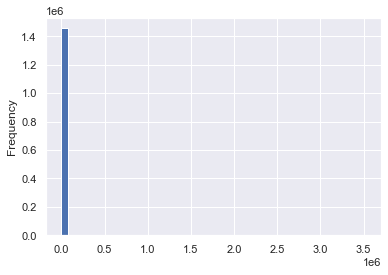

In [6]:
df_train['trip_duration'].plot.hist(bins=50)

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

<AxesSubplot:ylabel='Frequency'>

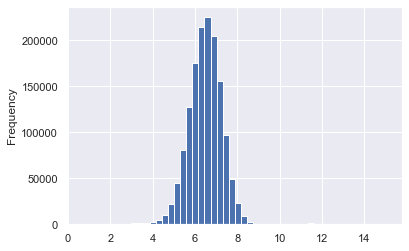

In [7]:
df_train['log_trip_duration'] = np.log1p(df_train['trip_duration'])
df_train['log_trip_duration'].plot.hist(bins=50)

In [8]:
df_train.drop(columns='trip_duration', inplace=True)

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [9]:
from sklearn.metrics import mean_squared_error

In [10]:
df_train['const'] = df_train['log_trip_duration'].mean()

rmsle = mean_squared_error(df_train['const'], df_train['log_trip_duration'], squared=False)

df_train.drop(columns='const', inplace=True)

rmsle

0.7957592365411509

## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

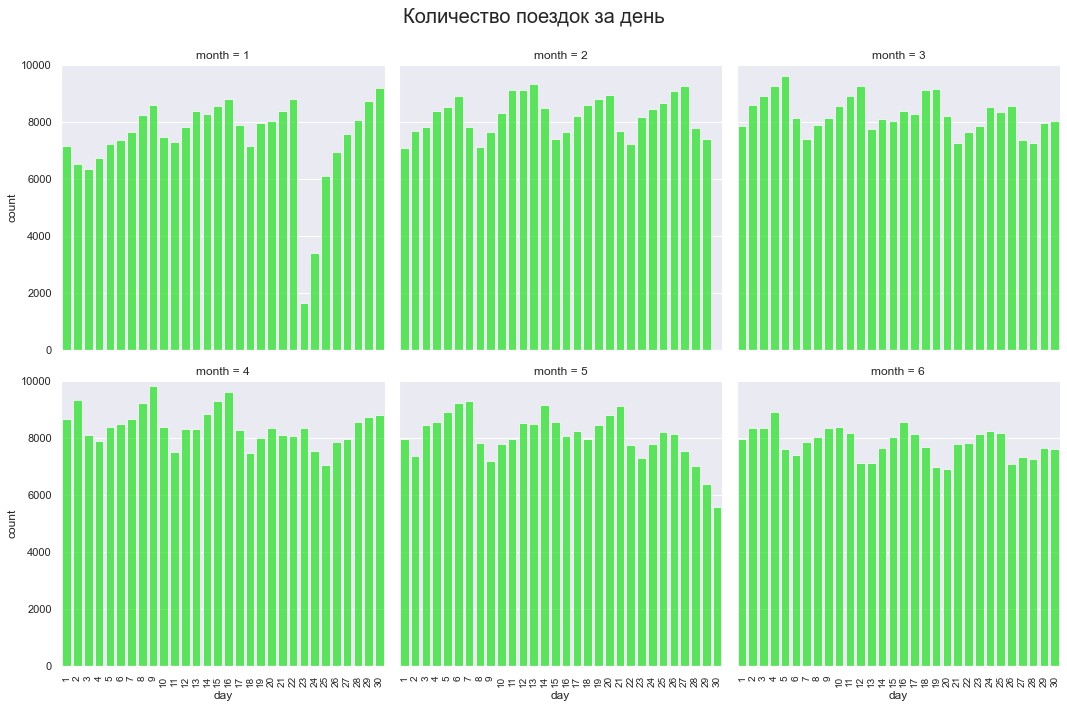

In [11]:
df_train['month'] = df_train['pickup_datetime'].dt.month
df_train['day'] = df_train['pickup_datetime'].dt.day

g = sns.FacetGrid(df_train, col='month', col_wrap=3, height=5, ylim=(0,10000))
g.map(sns.countplot, 'day', color='lime', alpha=0.7,
      order=[i for i in range(1,31)])
g.set_xticklabels(fontsize=10, rotation=90)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Количество поездок за день', fontsize=20)

df_train.drop(columns=['month','day'], inplace=True)

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

**Ответ**: На графиках видны несколько дней, в которых количество поездок было значительно ниже, чем обычно: 
* 23-24 января 2016 (в эти дни в Нью-Йорке была аномальная метель)
* 30 мая (день поминовения в США?)

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

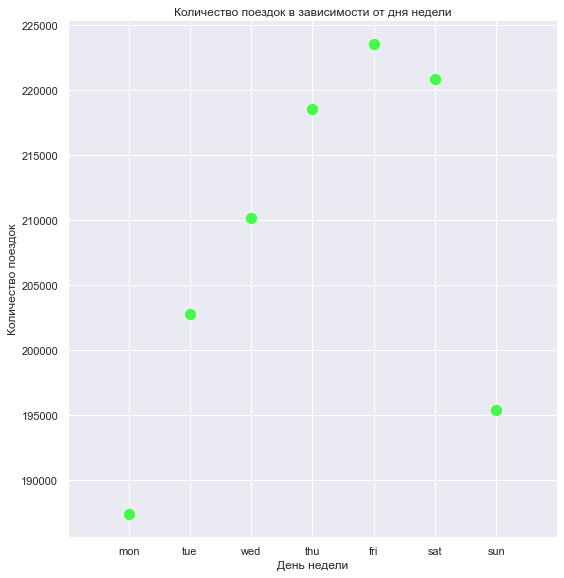

In [12]:
df_train['day_of_week'] = df_train['pickup_datetime'].dt.day_of_week
ax = sns.relplot(x=df_train['day_of_week'].value_counts().index,
                 y=df_train['day_of_week'].value_counts().values,
                 s=150, color='lime', alpha=0.7, height=8)
ax.set(title='Количество поездок в зависимости от дня недели',
       xlabel='День недели',
       ylabel='Количество поездок')
ax.set_xticklabels(['','mon','tue','wed','thu','fri','sat','sun',''])

df_train.drop(columns='day_of_week', inplace=True)

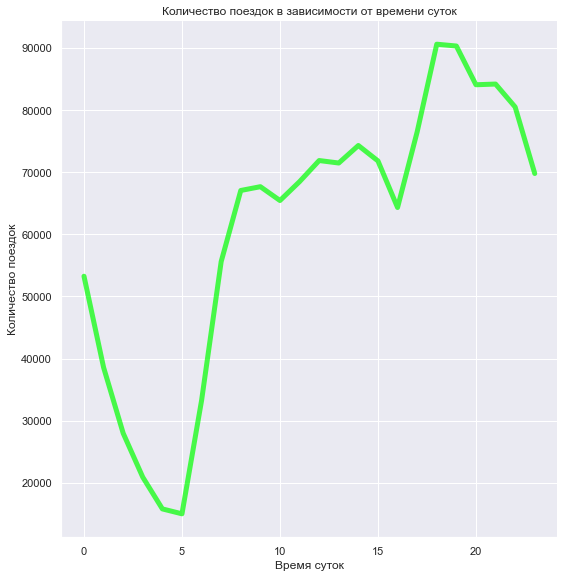

In [13]:
df_train['hour'] = df_train['pickup_datetime'].dt.hour
ax = sns.relplot(x=df_train['hour'].value_counts().index,
                 y=df_train['hour'].value_counts().values,
                 color='lime', alpha=0.7, kind='line',
                 height=8, linewidth=5) 
ax.set(title='Количество поездок в зависимости от времени суток',
       xlabel='Время суток',
       ylabel='Количество поездок')

df_train.drop(columns='hour', inplace=True)

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

In [14]:
df_train['hour'] = df_train['pickup_datetime'].dt.hour
df_train['month'] = df_train['pickup_datetime'].dt.month

gb_month_hour = pd.DataFrame(df_train.groupby(by=['month','hour'])['id'].count())
gb_month_hour.reset_index(level=['month','hour'], inplace=True)

df_train.drop(columns=['hour','month'], inplace=True)

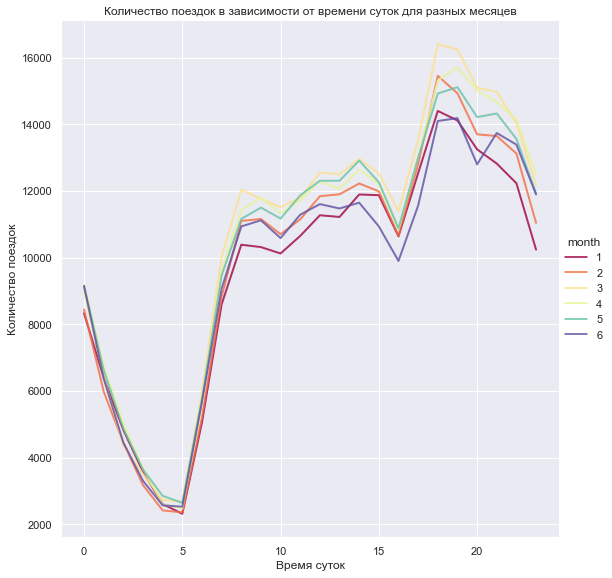

In [15]:
ax = sns.relplot(data=gb_month_hour, x='hour', y='id',
                 alpha=0.8, kind='line', palette='Spectral',
                 height=8, linewidth=2, hue='month')
ax.set(title='Количество поездок в зависимости от времени суток для разных месяцев',
       xlabel='Время суток',
       ylabel='Количество поездок')

In [16]:
df_train['day_of_week'] = df_train['pickup_datetime'].dt.day_of_week
df_train['hour'] = df_train['pickup_datetime'].dt.hour

gb_dow_hour = pd.DataFrame(df_train.groupby(by=['day_of_week','hour'])['id'].count())
gb_dow_hour.reset_index(level=['day_of_week','hour'], inplace=True)

df_train.drop(columns=['day_of_week','hour'], inplace=True)

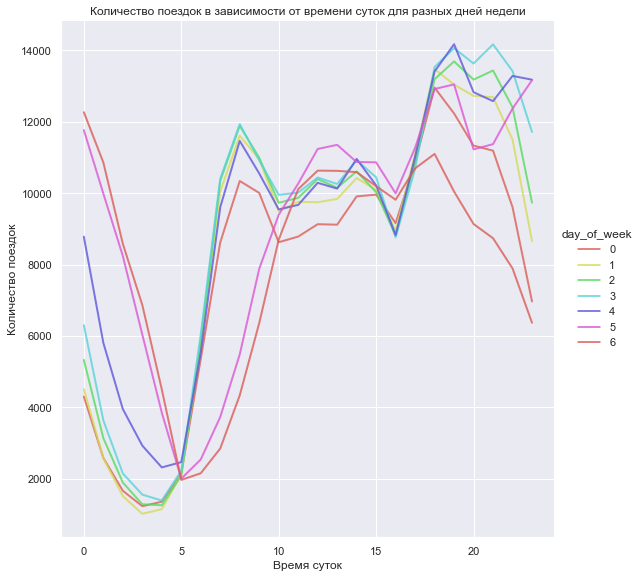

In [17]:
ax = sns.relplot(data=gb_dow_hour, x='hour', y='id',
                 alpha=0.8, kind='line', palette='hls',
                 height=8, linewidth=2, hue='day_of_week')
ax.set(title='Количество поездок в зависимости от времени суток для разных дней недели',
       xlabel='Время суток',
       ylabel='Количество поездок')

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Ответ**: 
В разные месяцы зависимость количества поездок от времени суток значительно не менялась.

В субботу и воскресенье зависимость количества поездок от времени суток отличается от зависимости в будние дни:
* В период с 00 до 05 часов в выходные дни поездок больше, чем в будние дни (вероятнее всего, многие в это время возвращаются из баров, ресторанов, от друзей и т.д.)
* В период с 20 до 23 в пятницу и субботу также заметно увеличение количества поездок (можно объяснить теми же самыми причинами)
* В будние дни есть два периода с высокой активностью: 7 - 9 и 18 - 21, которых нет в выходные (люди едут на работу и возвращаюся с нее в это время)

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [18]:
df_train['day_of_week'] = df_train['pickup_datetime'].dt.day_of_week

gb_dow_target = pd.DataFrame(df_train.groupby(by=['day_of_week'])['log_trip_duration'].mean())
gb_dow_target.reset_index(level=['day_of_week'], inplace=True)

df_train.drop(columns='day_of_week', inplace=True)

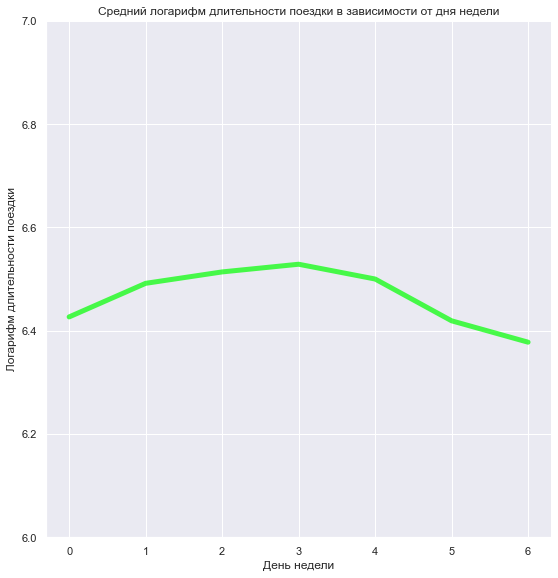

In [19]:
ax = sns.relplot(data=gb_dow_target, x='day_of_week',
                 y='log_trip_duration',
                 color='lime', alpha=0.7, kind='line',
                 height=8, linewidth=5) 

ax.set(title='Средний логарифм длительности поездки в зависимости от дня недели',
       xlabel='День недели',
       ylabel='Логарифм длительности поездки', ylim=(6,7))

In [20]:
df_train['hour'] = df_train['pickup_datetime'].dt.hour

gb_hour_target = pd.DataFrame(df_train.groupby(by=['hour'])['log_trip_duration'].mean())
gb_hour_target.reset_index(level=['hour'], inplace=True)

df_train.drop(columns='hour', inplace=True)

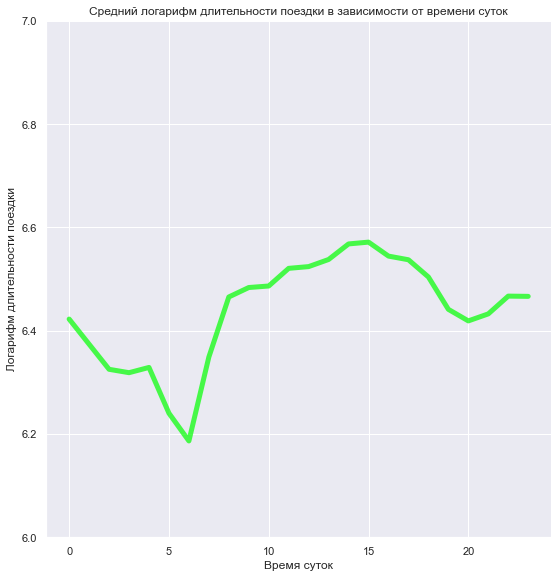

In [21]:
ax = sns.relplot(data=gb_hour_target, x='hour',
                 y='log_trip_duration',
                 color='lime', alpha=0.7, kind='line',
                 height=8, linewidth=5)

ax.set(title='Средний логарифм длительности поездки в зависимости от времени суток',
       xlabel='Время суток',
       ylabel='Логарифм длительности поездки', ylim=(6, 7))


In [22]:
df_train['month'] = df_train['pickup_datetime'].dt.month
df_train['day'] = df_train['pickup_datetime'].dt.day

gb_md = pd.DataFrame(df_train.groupby(by=['month','day'])['log_trip_duration'].mean())
gb_md.reset_index(level=['month','day'], inplace=True)

df_train.drop(columns=['day','month'], inplace=True)

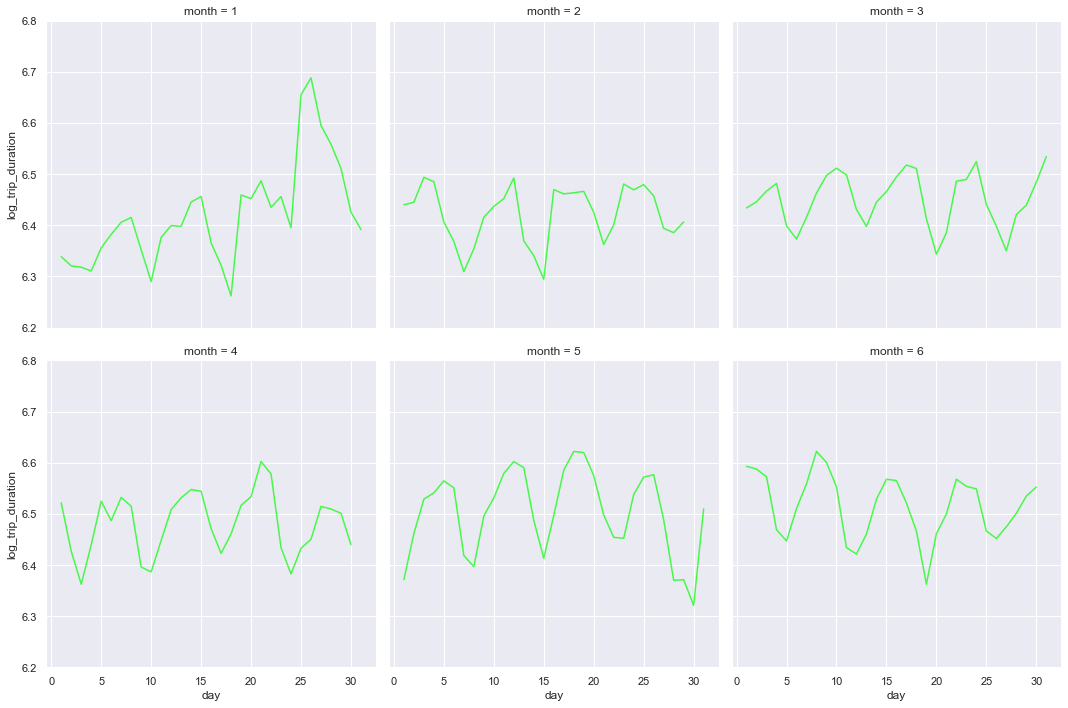

In [23]:
g = sns.FacetGrid(gb_md, col='month', col_wrap=3, height=5, ylim=(6.2,6.8))
g.map(sns.lineplot, 'day','log_trip_duration', color='lime', alpha=0.7)

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [24]:
def new_columns(df):
    return df.assign(
        day_of_week=df['pickup_datetime'].dt.day_of_week,
        month=df['pickup_datetime'].dt.month,
        hour=df['pickup_datetime'].dt.hour,
        is_anomaly_1=((df['pickup_datetime'].dt.day == 23) & (df['pickup_datetime'].dt.month == 1)) |\
                     ((df['pickup_datetime'].dt.day == 24) & (df['pickup_datetime'].dt.month == 1)) |\
                     ((df['pickup_datetime'].dt.day == 25) & (df['pickup_datetime'].dt.month == 1)),
        is_anomaly_2=((df['pickup_datetime'].dt.day == 30) & (df['pickup_datetime'].dt.month == 5)),
        day_of_year=df['pickup_datetime'].dt.day_of_year)

In [25]:
df_train = new_columns(df_train)
df_test = new_columns(df_test)

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [26]:
df_train.to_csv('df_train_1.csv', index=False)

(Кросс-валидация вынесена в отдельный ноутбук 'cv.ipynb', под заголовком '1')

## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [27]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [28]:
show_circles_on_map(df_train.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [29]:
show_circles_on_map(df_train.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте?

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [30]:
from haversine import haversine

In [31]:
df_train['haversine'] = df_train.apply(lambda x: haversine((x.pickup_latitude, x.pickup_longitude),
                                               (x.dropoff_latitude,x.dropoff_longitude)),
                                       axis=1)

In [32]:
df_test['haversine'] = df_test.apply(lambda x: haversine((x.pickup_latitude, x.pickup_longitude),
                                               (x.dropoff_latitude,x.dropoff_longitude)),
                                     axis=1)

In [33]:
# корреляция нового признака с логарифмом таргета
df_train[['haversine','log_trip_duration']].corr()['haversine']['log_trip_duration']

0.5735948311180449

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [34]:
df_train['log_haversine'] = np.log1p(df_train['haversine'])

In [35]:
df_test['log_haversine'] = np.log1p(df_test['haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [36]:
df_train[['log_haversine','log_trip_duration']].corr()['log_haversine']['log_trip_duration']

0.7498822628897813

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

<AxesSubplot:ylabel='Frequency'>

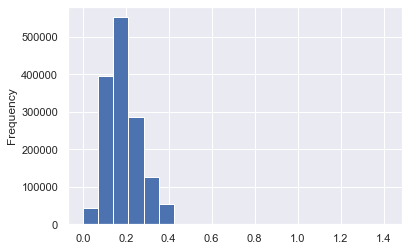

In [37]:
df_train['av_speed_loglog'] = df_train['log_haversine'] / df_train['log_trip_duration']
df_train['av_speed_loglog'].plot.hist(bins=20)

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

<AxesSubplot:ylabel='Frequency'>

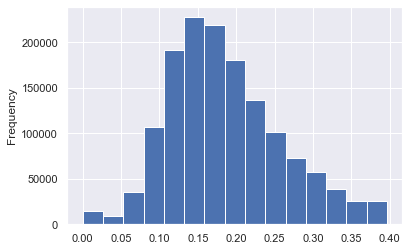

In [38]:
df_train[df_train['av_speed_loglog'] < df_train['av_speed_loglog'].quantile(q=0.99)]['av_speed_loglog'].plot.hist(bins=15)

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

In [39]:
gb_dow_hour_median = pd.DataFrame(df_train.groupby(by=['day_of_week','hour'])['av_speed_loglog'].median())
gb_dow_hour_median = gb_dow_hour_median.unstack()

Text(84.5, 0.5, 'День недели')

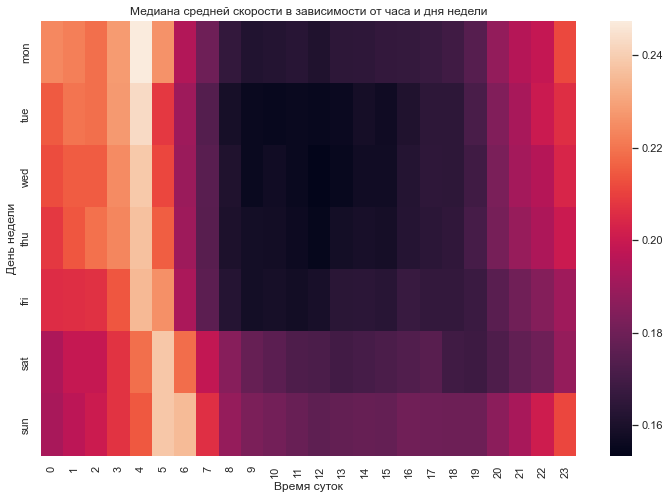

In [40]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(gb_dow_hour_median)
ax.set_yticklabels(['mon','tue','wed','thu','fri','sat','sun'])
ax.set_xticklabels([i for i in range(24)]); # ';' удаляет лишний текст перед графиком
ax.set_title('Медиана средней скорости в зависимости от часа и дня недели')
ax.set_xlabel('Время суток')
ax.set_ylabel('День недели')

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

**Ответ**: для его рассчета используется таргет. в тестовом наборе данных мы не сможем его рассчитать

In [41]:
df_train.drop(columns='av_speed_loglog', inplace=True)

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [42]:
# реализация трансформера, создающего данные признаки, вынесена в модуль transformers
from transformers import *

In [43]:
tht = TraficHoursTransformer()

In [44]:
df_train = tht.fit_transform(df_train)
df_test = tht.transform(df_test)

**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

In [45]:
pass

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

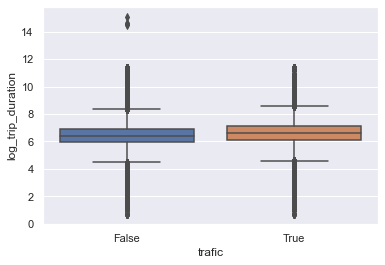

In [46]:
ax = sns.boxplot(x='trafic',y='log_trip_duration', data=df_train)

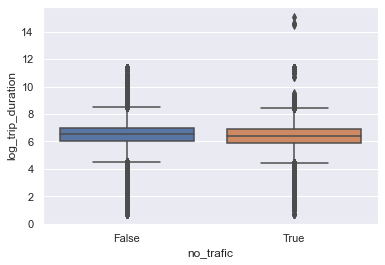

In [47]:
ax = sns.boxplot(x='no_trafic',y='log_trip_duration', data=df_train)

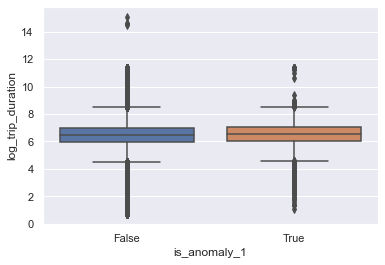

In [48]:
ax = sns.boxplot(x='is_anomaly_1',y='log_trip_duration', data=df_train)

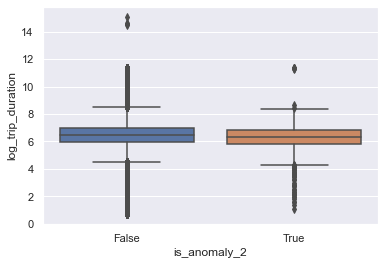

In [49]:
ax = sns.boxplot(x='is_anomaly_2',y='log_trip_duration', data=df_train)

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [50]:
# реализация трансформера находится в модуле transformers
mgt = MapGridTransformer(5, 5)

In [51]:
df_train = mgt.fit_transform(df_train)
df_test = mgt.transform(df_test)

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [52]:
df_train.to_csv('df_train_2.csv', index=False)

(Кросс-валидация вынесена в отдельный ноутбук 'cv.ipynb', под заголовком '2')

## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [53]:
df_train['passenger_count'].value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
8          1
9          1
Name: passenger_count, dtype: int64

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

<AxesSubplot:xlabel='passenger_count', ylabel='log_trip_duration'>

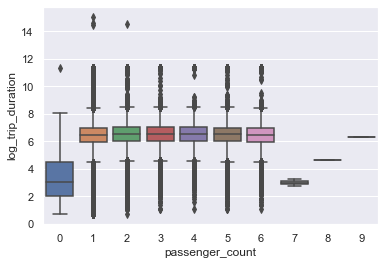

In [54]:
sns.boxplot(x="passenger_count", y="log_trip_duration", data=df_train)

Данный признак можно использовать для очистки данных: оставить только объекты с значением 'passenger_count' на отрезке [1,6]. Объектов с другими значениями мало, они похожи на ошибку в данных и могут привести к переобучению. Сам признак использовать в обучении неперспективно.

In [55]:
df_train = df_train[df_train['passenger_count'].isin([1,2,3,4,5,6])]
df_train.drop(columns='passenger_count', inplace=True)
df_test.drop(columns='passenger_count', inplace=True)

In [56]:
df_train['vendor_id'].value_counts()

2    780268
1    678311
Name: vendor_id, dtype: int64

<AxesSubplot:xlabel='vendor_id', ylabel='log_trip_duration'>

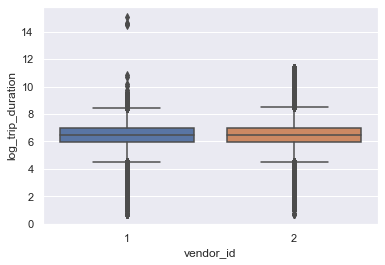

In [57]:
sns.boxplot(x="vendor_id", y="log_trip_duration", data=df_train)

In [58]:
df_train.groupby(by='vendor_id')['log_trip_duration'].mean()

vendor_id
1    6.450260
2    6.481746
Name: log_trip_duration, dtype: float64

In [59]:
df_train[['vendor_id', 'log_trip_duration']].corr()['vendor_id']['log_trip_duration']

0.019743407270013672

Данный признак также почти не влияет на таргет

In [60]:
df_train.drop(columns='vendor_id', inplace=True)
df_test.drop(columns='vendor_id', inplace=True)

In [61]:
df_train['store_and_fwd_flag'].value_counts()

N    1450537
Y       8042
Name: store_and_fwd_flag, dtype: int64

<AxesSubplot:xlabel='store_and_fwd_flag', ylabel='log_trip_duration'>

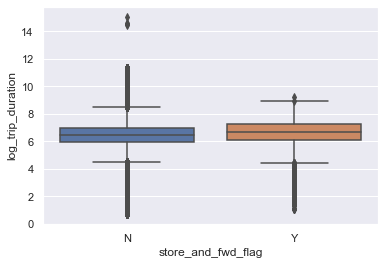

In [62]:
sns.boxplot(x='store_and_fwd_flag', y='log_trip_duration', data=df_train)

In [63]:
df_train.groupby(by='store_and_fwd_flag')['log_trip_duration'].mean()

store_and_fwd_flag
N    6.466188
Y    6.632181
Name: log_trip_duration, dtype: float64

In [64]:
df_train['store_and_fwd_flag'] = df_train['store_and_fwd_flag'].replace({'N':0,'Y':1})

In [65]:
df_test['store_and_fwd_flag'] = df_test['store_and_fwd_flag'].replace({'N':0,'Y':1})

In [66]:
df_train[['store_and_fwd_flag', 'log_trip_duration']].corr()['store_and_fwd_flag']['log_trip_duration']

0.015452759653040377

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [67]:
pass

Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

<AxesSubplot:ylabel='Frequency'>

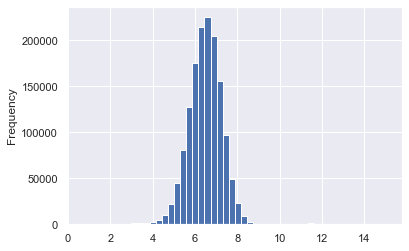

In [68]:
df_train['log_trip_duration'].plot.hist(bins=50)

1. Удалим из выборки поездки, которые длились ~ менее минуты, предполагая, что это выбросы

In [69]:
np.log1p(60)

4.110873864173311

In [70]:
df_train.shape[0]

1458579

In [71]:
df_train = df_train[df_train['log_trip_duration'] > 4]

In [72]:
df_train.shape[0]

1450930

2. Удалим поездки с очень большим пройденным расстоянием (маловероятно, что расстояние поездки по городу превышает ~ 100 км)

<AxesSubplot:ylabel='Frequency'>

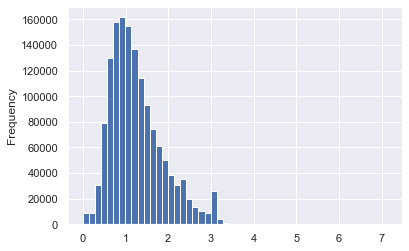

In [73]:
df_train['log_haversine'].plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

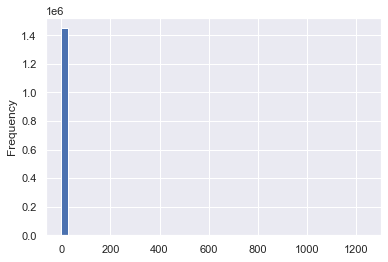

In [74]:
# не логарифмированное расстояние поездки
pd.Series(np.expm1(df_train['log_haversine'])).plot.hist(bins=50)

In [75]:
np.log1p(100)

4.61512051684126

In [76]:
df_train.shape[0]

1450930

In [77]:
df_train = df_train[df_train['log_haversine'] < 4.6]

In [78]:
df_train.shape[0]

1450911

3. Удалим поездки с большими остатками регрессии

In [79]:
df_train[:3]

,id,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,day_of_week,month,hour,is_anomaly_1,is_anomaly_2,day_of_year,haversine,log_haversine,trafic,no_trafic,pickup_square,dropoff_square
0,id2875421,2016-03-14 17:24:55,-73.982155,40.767937,-73.964630,40.765602,0,6.122493,0,3,17,False,False,74,1.498523,0.915700,True,False,15,16
1,id2377394,2016-06-12 00:43:35,-73.980415,40.738564,-73.999481,40.731152,0,6.498282,6,6,0,False,False,164,1.805510,1.031585,False,True,10,10
2,id3858529,2016-01-19 11:35:24,-73.979027,40.763939,-74.005333,40.710087,0,7.661527,1,1,11,False,False,19,6.385107,1.999465,True,False,15,5


In [80]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(df_train.drop(columns=['id','pickup_datetime','log_trip_duration']), df_train['log_trip_duration'])
df_train['lr_prediction'] = model.predict(df_train.drop(columns=['id','pickup_datetime','log_trip_duration']))
df_train['residual'] = df_train['log_trip_duration'] - df_train['lr_prediction']

<AxesSubplot:ylabel='Frequency'>

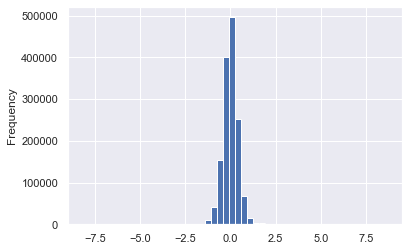

In [81]:
df_train['residual'].plot.hist(bins=50)

In [82]:
df_train.shape[0]

1450911

In [83]:
df_train = df_train[abs(df_train['residual']) < 3]

In [84]:
df_train.shape[0]

1448746

In [85]:
df_train.drop(columns=['lr_prediction','residual'], inplace=True)

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

In [86]:
pass

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [87]:
pass

Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [88]:
df_train.to_csv('df_train_3.csv', index=False)

Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [ ]:
# файл cv, под заголовком 4

Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [ ]:
# файл cv, под заголовком 6

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [89]:
df_train['p_d_square'] = (df_train['pickup_square'].astype('str') +
                          '_' +
                          df_train['dropoff_square'].astype('str'))

In [106]:
df_test['p_d_square'] = (df_test['pickup_square'].astype('str') +
                         '_' +
                         df_test['dropoff_square'].astype('str'))

In [102]:
most_common_pairs = df_train['p_d_square'].value_counts()[:100].index

In [107]:
df_train['p_d_square'] = df_train['p_d_square'].apply(lambda x: x if x in most_common_pairs else '-1')
df_test['p_d_square'] = df_test['p_d_square'].apply(lambda x: x if x in most_common_pairs else '-1')

In [110]:
df_train.to_csv('df_train_5.csv', index=False)
df_test.to_csv('df_test_5.csv', index=False)

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [ ]:
# файл cv, под заголовком 5

**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.